# Data Exploration and Pre-Processing

This dataset contains chest x-ray images some of which are labeled as 'NORMAL' and otheras as 'PNEUMONIA' which are examples of patients that indeed have a case the potentially lethal respiratory infection. There are 5656 total images in a range of dimensions and all are greyscale. The dataset is sourced directly from [this Kaggle page](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) using the Kaggle API command (kaggle datasets download -d paultimothymooney/chest-xray-pneumonia). This kaggle page cites [Mendeley Data](https://data.mendeley.com/datasets/rscbjbr9sj/2) as its original data source.  

## Data loading and sifting

In [2]:
# dependences for data loading and sifting
import os
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [87]:
# file paths to data directories
train_dir = "data/train/"
test_dir = "data/test/"
val_dir = "data/val/"

# dictionary of volume of data per class per sample
class_balance_dict = {
    "Train Sample":[len(os.listdir(train_dir+"NORMAL")),len(os.listdir(train_dir+"PNEUMONIA"))],
    "Test Sample":[len(os.listdir(test_dir+"NORMAL")),len(os.listdir(test_dir+"PNEUMONIA"))],
    "Val Sample":[len(os.listdir(val_dir+"NORMAL")),len(os.listdir(val_dir+"PNEUMONIA"))]
}

# class balance dictionary as a dataframe with row index representing class and column index representing sample
import pandas as pd
class_balance_df = pd.DataFrame(class_balance_dict,index=['Normal', 'Pneumonia'])
class_balance_df

,Train Sample,Test Sample,Val Sample
Normal,1341,234,8
Pneumonia,3875,390,8


Text(0, 0.5, 'Percent Class Representation')

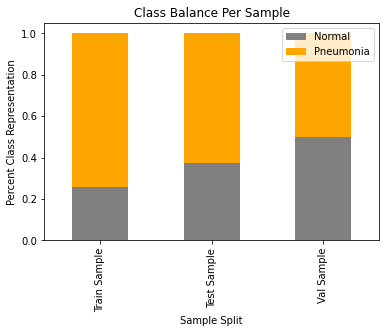

In [88]:
import matplotlib.pyplot as plt

# normalize data as percentage and rotate for plotting
class_balance_normalized = class_balance_df.T.apply(lambda x: x/x.sum(), axis=1)
 
# create stacked bar chart for students DataFrame
class_balance_normalized.plot(kind='bar', stacked=True, color=['gray', 'orange',])

# Add Title and Labels
plt.title('Class Balance Per Sample')
plt.xlabel('Sample Split')
plt.ylabel('Percent Class Representation')

The data comes already labeled and split for 3 way validation. The Train sample is, naturally, the largest of the 3 with over five thousand images, 66% of which are cases of pneumonia which will be the target prediction. The next largest is the test sample with over six hundred images of which 40% are trues cases of pneumonia. Finally, the validation set contains 16 images with each class being represented equally at 50%.  

## Sanity Check: Can the images be displayed easily?

In [6]:
# an example of (first) and Normal x-ray scan and (second) and x-ray scan showing pneumonia
Image.open("data/train/NORMAL/IM-0115-0001.jpeg").show()
Image.open("data/train/PNEUMONIA/person1001_bacteria_2932.jpeg").show()

## Generate Data from Sub-Directory Structure

In [91]:
# dependencies for modeling
from keras import layers
from keras import models
from keras import optimizers

In [92]:
# instatiating a data degenerater for each split sample 
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)
                                   
val_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_directory(
                       train_dir,
                       target_size=(150,150),
                       batch_size=16,
                       class_mode='binary',
                       color_mode='grayscale')

test_data_generator = test_datagen.flow_from_directory(
                      test_dir,
                      target_size=(150,150),
                      batch_size=16,
                      class_mode='binary',
                      color_mode='grayscale')

val_data_generator = val_datagen.flow_from_directory(
                     val_dir,
                     target_size=(150,150),
                     batch_size=16,
                     class_mode='binary',
                     color_mode='grayscale')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### Generate Structured Data from Generators for Use With SciKit Learn Tools

In [ ]:
columns=['batch_size', 'height', 'width', 'channels']

In [158]:
# Get the data and labels for the batch
data_array = next(val_data_generator)
data, labels = data_array
# df = pd.DataFrame(data=data)
# df["Labels"] = labels

data.shape

(16, 150, 150, 1)

In [170]:
data[0][0]

array([[0.00784314],
       [0.00784314],
       [0.00392157],
       [0.00392157],
       [0.00392157],
       [0.00392157],
       [0.        ],
       [0.        ],
       [0.9333334 ],
       [0.        ],
       [0.02352941],
       [0.03921569],
       [0.04313726],
       [0.05882353],
       [0.07058824],
       [0.07058824],
       [0.07450981],
       [0.05882353],
       [0.07843138],
       [0.0627451 ],
       [0.        ],
       [0.07450981],
       [0.07058824],
       [0.06666667],
       [0.09411766],
       [0.18431373],
       [0.23137257],
       [0.3137255 ],
       [0.35686275],
       [0.45882356],
       [0.5137255 ],
       [0.5803922 ],
       [0.54509807],
       [0.6784314 ],
       [0.7019608 ],
       [0.6627451 ],
       [0.68235296],
       [0.6784314 ],
       [0.6862745 ],
       [0.69803923],
       [0.6313726 ],
       [0.60784316],
       [0.6431373 ],
       [0.68235296],
       [0.6627451 ],
       [0.6313726 ],
       [0.64705884],
       [0.639

In [ ]:
datagenerators = [train_data_generator,test_data_generator,val_data_generator]

for generator in datagenerators:
    for batch in generator:
        


## Sanity Check: is the data ready to fit a model?

In [6]:
# build a simple convultional neural network
base_model = models.Sequential()
base_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
base_model.add(layers.MaxPooling2D((2, 2)))
base_model.add(layers.Flatten())
base_model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
# compile model from above
base_model.compile(loss='binary_crossentropy',metrics=['acc'])

In [8]:
# fit the model to the training data and validate with the test sample
base_model.fit(train_data_generator, 
               batch_size=16,
               epochs=10,
               steps_per_epoch=25,
               validation_data=test_data_generator,
               validation_steps=15
               )

Epoch 1/10
25/25 [==============================] - 12s 465ms/step - loss: 1.2679 - acc: 0.6725 - val_loss: 0.7709 - val_acc: 0.5958
Epoch 2/10
25/25 [==============================] - 10s 387ms/step - loss: 0.4802 - acc: 0.7925 - val_loss: 0.4146 - val_acc: 0.8083
Epoch 3/10
25/25 [==============================] - 10s 380ms/step - loss: 0.3592 - acc: 0.8500 - val_loss: 1.0781 - val_acc: 0.5917
Epoch 4/10
25/25 [==============================] - 9s 351ms/step - loss: 0.2379 - acc: 0.9125 - val_loss: 0.2722 - val_acc: 0.9083
Epoch 5/10
25/25 [==============================] - 9s 341ms/step - loss: 0.2137 - acc: 0.9225 - val_loss: 0.3865 - val_acc: 0.8000
Epoch 6/10
25/25 [==============================] - 8s 328ms/step - loss: 0.1705 - acc: 0.9425 - val_loss: 0.4427 - val_acc: 0.7750
Epoch 7/10
25/25 [==============================] - 9s 341ms/step - loss: 0.1776 - acc: 0.9325 - val_loss: 0.3138 - val_acc: 0.8500
Epoch 8/10
25/25 [==============================] - 8s 319ms/step - loss:

In [130]:
train_batches = len(train_data_generator)
test_batches = len(test_data_generator)
val_batches = len(val_data_generator)

In [127]:
X,y = val_data_generator[0][0],val_data_generator[0][1]

In [129]:
y

array([1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1.],
      dtype=float32)

In [ ]:
np.asarray(val_data_generator)

## Conlcusion 
The base model succesfully compiles and fits without any errors or warnings. The model also performs decently for a baseline model. I will continue tuning and optimizing thhe model in the [modeling notebook](/PROJECT-2/modeling.ipynb).  